This program is part of pyHNC, copyright (c) 2023 Patrick B Warren (STFC).
Additional modifications copyright (c) 2025 Joshua F Robinson (STFC).
Email: patrick.warren{at}stfc.ac.uk.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see
<http://www.gnu.org/licenses/>.

Demonstrate the capabilities of the HNC package for solving DPD
potentials, comparing with SunlightHNC if requested, and plotting
the pair distribution function and the structure factor too.  For
details here see also the SunlightHNC documentation.

For standard DPD at $A = 25$ and $ρ = 3$, we have the following table

```
          ∆t = 0.02   ∆t = 0.01   Monte-Carlo  HNC   deviation
pressure  23.73±0.02  23.69±0.02  23.65±0.02   23.564  (0.4%)
energy    13.66±0.02  13.64±0.02  13.63±0.02   13.762  (1.0%)
mu^ex     12.14±0.02  12.16±0.02  12.25±0.10   12.170  (0.7%)
```


The first two columns are from dynamic simulations.  The excess
chemical potential (final row) is measured by Widom insertion.  The
HNC results from the present code are in agreement with those from
SunlightHNC to at least the indicated number of decimals.  The
deviation is between HNC and simulation results.

Data is from a forthcoming publication on osmotic pressure in DPD.

## Standard modules

In [4]:
import os
import pyHNC
import argparse
import pandas as pd
import numpy as np, matplotlib.pyplot as plt
from numpy import pi as π
from scipy.integrate import simpson
from pyHNC import Grid, PicardHNC, SolutePicardHNC, truncate_to_zero
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = 10, 7

## Global parameters

In [3]:
N = 2**15
Δr = 0.01
grid = Grid(N, Δr)
r, q = grid.r, grid.q

verbose = False

alpha = 0.2
npicard = 1000
tol = 1e-12
solvent = PicardHNC(grid, alpha=alpha, npicard=npicard, tol=tol)
print(grid.details + '\n' + solvent.details)

Grid: ng = 32768 = 2^15, Δr = 0.01, Δq = 0.00959, |FFTW arrays| = 32767
HNC: α = 0.2, tol = 1.0e-12, npicard = 1000


In [14]:
round(np.log2(grid.ng))

15

# 1. Solve for pure solvent

Define interaction parameters:

In [5]:
def dpd_potential(A, r):
    """Define the DPD potential."""
    return truncate_to_zero(A/2*(1-r)**2, r, 1)

def dpd_force(A, r):
    """Define dereivative of the DPD potential."""
    return truncate_to_zero(A*(1-r), r, 1) # the force f = -dφ/dr

# Parameters for solvent-solvent interactions
A00 = 25
ρ0 = 3.0
φ0, f0 = dpd_potential(A00, r), dpd_force(A00, r)

Solve for $h(r)$ via Picard iteration with HNC closure:

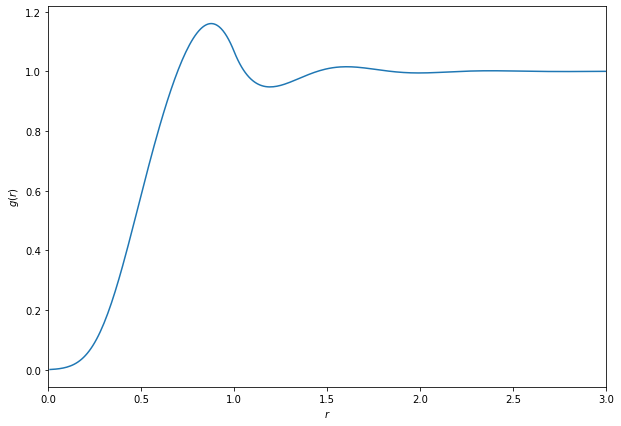

In [6]:
soln = solvent.solve(φ0, ρ0, monitor=verbose) # solve for the DPD potential
h00, c00, h00q = soln.hr, soln.cr, soln.hq # extract for use in a moment

plt.plot(r, 1+h00)
plt.xlabel('$r$')
plt.ylabel('$g(r)$')
plt.xlim([0, 3])
plt.show()

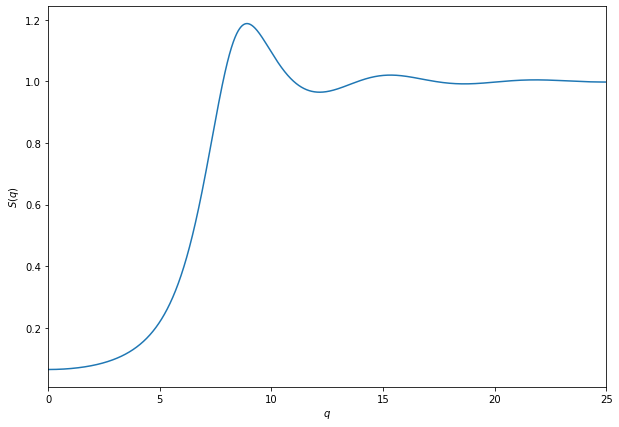

In [7]:
S00q = 1 + ρ0*h00q # solvent structure factor

plt.plot(q, S00q)
plt.xlabel('$q$')
plt.ylabel('$S(q)$')
plt.xlim([0, 25])
plt.show()

Calculate thermodynamic quantities using the total correlation function $h(r)$.

For the integrals here, see Eqs. (2.5.20) and (2.5.22) in Hansen & McDonald, "Theory of Simple Liquids" (3rd edition): for the (excess) energy density,
$$
e \equiv \frac{U^\mathrm{ex}}{V} = 2\pi\rho^2 \int_0^\infty \mathrm{d}r \, r^2 \phi(r) g(r)
$$
and virial pressure,
$$
p = \rho + \frac{2\pi\rho^2}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) g(r)
$$
where $f(r) = −\mathrm{d}\phi/\mathrm{d}r$ is the force. Note that we have assumed $\beta = 1$ in our expressions, so energy is given in units of $k_\mathrm{B} T$. An integration by parts shows that the mean-field contributions, being these with g(r) = 1, are the same.

Here specifically the mean-field contributions are
$$
\frac{2\pi \rho^3}{3} \int_0^\infty \mathrm{d}r \, r^3 f(r) = A \int_0^1 \mathrm{d}r \, r^3 (1−r) = \frac{\pi A \rho^3}{30} \,.
$$

In [8]:
def excess_chemical_potential(h, c, r):
    return 4*π*ρ0 * simpson(r**2*(h*(h-c)/2 - c), r)

μ_ex = excess_chemical_potential(h00, c00, r)
μ = np.log(ρ0) + μ_ex
print(f'μ={μ:.4f} μ_ex={μ_ex:.4f} μ_id={μ-μ_ex:.4f}')

μ=13.2692 μ_ex=12.1706 μ_id=1.0986


# 2. Introduce solute

We need to use a different solver that takes into account that this is now a binary mixture where the second species (the solute) is infinitely dilute. We need to pass the previously obtained static properties of the solvent.

In [9]:
solute = SolutePicardHNC(ρ0*h00q, grid, alpha=alpha, npicard=npicard, tol=tol)

Show how the distribution function $g_{01}$ between solvent (species 0) and solute (species 1) varies with DPD interaction parameter $A_{01}$. We can also infer $g_{11}$ directly from $g_{01}$ and thereby calculate the potential of mean force between two solute particles:
$$
- \ln{g_{11}(r)} = \beta \phi_{11}(r) + \beta \Delta \Omega_{11}(r)\,.
$$
Here $\beta \Delta \Omega_{11}$ is the depletion potential between solutes.

/tmp/ipykernel_28546/127677790.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/tmp/ipykernel_28546/127677790.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


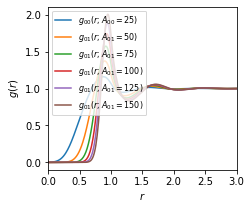

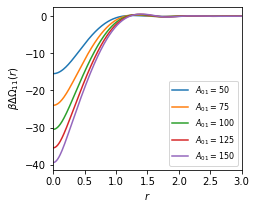

In [8]:
fig1 = plt.figure(figsize=(3.375, 3))
ax1 = plt.gca()
fig2 = plt.figure(figsize=(3.375, 3))
ax2 = plt.gca()

ax1.plot(r, 1+h00, label=(r'$g_{00}(r; A_{00}=' + f'{A00})$'))

for A01 in np.arange(2*A00, 151, 25):
    φ01 = dpd_potential(A01, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    ax1.plot(r, 1+h01, label=(r'$g_{01}(r; A_{01}=' + f'{A01})$'))

    c01q = grid.fourier_bessel_forward(c01)
    depletion11 = - ρ0 * grid.fourier_bessel_backward(c01q * h01q)
    pl, = ax2.plot(r, depletion11, label=(r'$A_{01}=' + f'{A01}$'))

    # Equivalent calculation should be on top of other lines.
    # psi1q = h01q / (1 + ρ0*h00q)**0.5
    # depletion11 = - ρ0 * grid.fourier_bessel_backward(psi1q**2)
    # ax2.plot(r, depletion11, '--', c=pl.get_color())

for ax in [ax1, ax2]:
    ax.legend(loc='best', fontsize=8)
    ax.set_xlabel('$r$')
    ax.set_xlim([0, 3])

ax1.set_ylabel('$g(r)$')
ax2.set_ylabel(r'$\beta \Delta \Omega_{11}(r)$')

fig1.show()
fig2.show()

Calculate excess chemical potentials for solutes with varying solvent-solute interaction parameters $A_{01}$:

In [8]:
A01 = np.linspace(0, 60, 61)
μ_ex = np.empty(len(A01))
pmf_overlap = np.empty(len(A01))

for i, A in enumerate(np.flipud(A01)[:-1]):
    φ01 = dpd_potential(A, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, c01q, h01q = soln.hr, soln.cr, soln.cq, soln.hq
    μ_ex[len(A01)-i-1] = excess_chemical_potential(h01, c01, r)
    pmf_overlap[len(A01)-i-1] = - ρ0 / (2*π**2) * simpson(q**2*c01q*h01q, q)

μ_ex[0] = 0.0
pmf_overlap[0] = 0.0

In [57]:
np.flipud(np.linspace(0, 60, 13))

array([60., 55., 50., 45., 40., 35., 30., 25., 20., 15., 10.,  5.,  0.])

Plot the previously calculated chemical potentials:
digitised from Fig 1 of Hendrikse *et al.*, PCCP **27**, 1554-66 (2025).


In [10]:
schema2 = {'quantity':str, 'A01':float, 'value':float, 'error':float, 'njobs':int, 'file':str}
muref = pd.read_csv('muref_all.dat', sep='\t', names=schema2.keys(), dtype=schema2)
muref

,quantity,A01,value,error,njobs,file
0,um,0.0,0.00000,0.000000,40,muref1a_mu.dat
1,mu,0.0,0.00000,0.000000,40,muref1a_mu.dat
2,um,5.0,3.14129,0.000153,40,muref1a_mu.dat
3,mu,5.0,2.98500,0.000166,40,muref1a_mu.dat
4,um,10.0,6.28258,0.000305,40,muref1a_mu.dat
...,...,...,...,...,...,...
83,mu,40.0,16.77160,0.024320,100,muref2_mu.dat
84,um,45.0,28.27410,0.000992,100,muref2_mu.dat
85,mu,45.0,18.02120,0.036838,100,muref2_mu.dat
86,um,50.0,31.41560,0.001103,100,muref2_mu.dat


In [10]:
A01 = 35
slice = (muref['quantity']=='mu') & (muref['A01'] == A01)
muref[slice]

,quantity,A01,value,error,njobs,file
15,mu,35.0,15.4121,0.022324,40,muref1a_mu.dat
37,mu,35.0,15.3976,0.018405,40,muref1b_mu.dat
59,mu,35.0,15.3980,0.013808,40,muref2a_mu.dat
81,mu,35.0,15.4002,0.014103,100,muref2_mu.dat


In [27]:
muref['njobs'].unique()

array([ 40, 100])

In [11]:
slice = (muref['quantity']=='mu') & (muref['file'] == 'muref2_mu.dat')
muex = muref[slice].set_index('A01')['value']
muex_err = muref[slice].set_index('A01')['error']
#muex = muref[slice][['A01', 'value']].groupby('A01').mean()['value']
pd.concat([muex, muex_err], axis=1)

,value,error
A01,,
0.0,0.00000,0.000000
5.0,2.98545,0.000116
10.0,5.67323,0.000294
15.0,8.08463,0.000631
20.0,10.24070,0.001395
25.0,12.16280,0.003214
30.0,13.87410,0.007110
35.0,15.40020,0.014103
40.0,16.77160,0.024320


In [24]:
slice = (muref['quantity']=='mu') & muref['file'].str.startswith('muref2')
muex = muref[slice][['A01', 'value']].groupby('A01').mean()['value']
muex

A01
0.0      0.000000
5.0      2.985515
10.0     5.673240
15.0     8.084485
20.0    10.240450
25.0    12.162750
30.0    13.874200
35.0    15.399100
40.0    16.765500
45.0    18.004000
50.0    19.144300
Name: value, dtype: float64

In [12]:
schema = {'quantity':str, 'A01':float, 'dlength':float, 'value':float, 'error':float, 'njobs':int, 'file':str}
dimer = pd.read_csv('dimer_all.dat', sep='\t', names=schema.keys(), dtype=schema)
dimer

,quantity,A01,dlength,value,error,njobs,file
0,um,0.0,0.0,0.00000,0.000000,40,dimer00a_mu.dat
1,mu,0.0,0.0,0.00000,0.000000,40,dimer00a_mu.dat
2,um,5.0,0.0,6.28258,0.000305,40,dimer00a_mu.dat
3,mu,5.0,0.0,5.67216,0.000462,40,dimer00a_mu.dat
4,um,10.0,0.0,12.56520,0.000611,40,dimer00a_mu.dat
...,...,...,...,...,...,...,...
499,mu,15.0,2.0,16.17420,0.003372,40,dimer20b_mu.dat
500,um,20.0,2.0,25.13520,0.001411,40,dimer20b_mu.dat
501,mu,20.0,2.0,20.50080,0.010541,40,dimer20b_mu.dat
502,um,25.0,2.0,31.41900,0.001764,40,dimer20b_mu.dat


In [12]:
schema = {'quantity':str, 'A01':float, 'dlength':float, 'value':float, 'error':float, 'njobs':int, 'file':str}
dimers = pd.read_csv('dimers_all.dat', sep='\t', names=schema.keys(), dtype=schema)
dimers

,quantity,A01,dlength,value,error,njobs,file
0,um,25.0,0.0,31.4190,0.001764,40,dimersa_mu.dat
1,mu,25.0,0.0,19.1818,0.069135,40,dimersa_mu.dat
2,um,30.0,0.0,37.7028,0.002116,40,dimersa_mu.dat
3,mu,30.0,0.0,21.3183,0.111053,40,dimersa_mu.dat
4,um,35.0,0.0,43.9866,0.002466,40,dimersa_mu.dat
...,...,...,...,...,...,...,...
407,mu,30.0,5.0,27.8203,0.050847,40,dimersy_mu.dat
408,um,40.0,5.0,50.2651,0.001403,40,dimersy_mu.dat
409,mu,40.0,5.0,34.1661,0.114877,40,dimersy_mu.dat
410,um,50.0,5.0,62.8314,0.001753,40,dimersy_mu.dat


In [20]:
np.sort(dimer['A01'].unique()), np.sort(dimers['A01'].unique())


(array([ 0.,  5., 10., 15., 20., 25.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]))

Text(0, 0.5, 'reduced PMF')

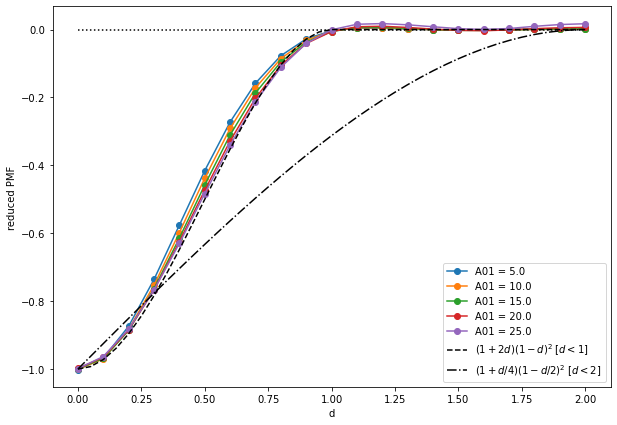

In [18]:
plt.plot([0, 2], [0, 0], 'k:')
for A01 in np.linspace(5, 25, 5):
    slice = (dimer['quantity'] == 'mu') & (dimer['A01'] == A01)
    muexdim = dimer[slice].groupby('dlength').mean()['value']
    plt.plot(muexdim.index, (muexdim-2*muex[A01])/(2*muex[A01]-muex[2*A01]), 'o-', label=f'A01 = {A01}')
    
d = np.linspace(0, 2, 41)
g = (1+2*d)*(1-d)**2
g[d>1] = 0
plt.plot(d, -g, 'k--', label='$(1+2d)(1-d)^2\;[d < 1]$')
R = 1
vov = (1+d/(4*R))*(1-d/(2*R))**2
vov[d>2*R] = 0
plt.plot(d, -vov, 'k-.', label='$(1+d/4)(1-d/2)^2\;[d<2]$')
plt.legend()
plt.xlabel('d')
plt.ylabel('reduced PMF')

In [37]:
slice = (dimers['quantity'] == 'mu') & (dimers['A01'] == 35)
ser35 = dimers[slice][['dlength', 'value']].groupby('dlength').mean()['value']
ser35

dlength
0.0    23.293450
0.1    23.593750
0.2    24.225750
0.3    25.115050
0.4    26.151450
0.5    27.254800
0.6    28.353550
0.7    29.354100
0.8    30.184800
0.9    30.792350
1.0    31.136167
1.1    31.318850
1.2    31.331250
1.3    31.301050
1.4    31.262100
1.5    31.203950
1.6    31.153250
1.7    31.167300
1.8    31.255750
1.9    31.334900
2.0    31.366867
3.0    31.118100
4.0    31.302700
5.0    31.393600
Name: value, dtype: float64

In [36]:
slice = (mudimer['quantity'] == 'mu') & (mudimer['dlength'] == 0.0)
mudimer[slice][['A01', 'value']].groupby('A01').mean()['value']

A01
0.0      0.000000
5.0      5.672815
10.0    10.239900
15.0    13.876050
20.0    16.778500
25.0    19.185700
Name: value, dtype: float64

In [48]:
slice = (muref['quantity']=='mu') & (muref['A01'] % 10 == 0)
muref[slice].set_index('A01')

A01
0.0      0.00000
10.0     5.67216
20.0    10.24010
30.0    13.88090
40.0    16.78660
50.0    19.18960
0.0      0.00000
10.0     5.67347
20.0    10.23970
30.0    13.87120
40.0    16.77040
50.0    19.18180
0.0      0.00000
10.0     5.67325
20.0    10.24020
30.0    13.87430
40.0    16.75940
50.0    19.10930
0.0      0.00000
10.0     5.67323
20.0    10.24070
30.0    13.87410
40.0    16.77160
50.0    19.17930
Name: value, dtype: float64

In [12]:
slice = (muref['quantity']=='mu') & muref['file'].str.startswith('muref2') & (muref['A01'] % 10 == 0)
muref[slice].set_index('A01')['value']

A01
0.0      0.00000
10.0     5.67325
20.0    10.24020
30.0    13.87430
40.0    16.75940
50.0    19.10930
0.0      0.00000
10.0     5.67323
20.0    10.24070
30.0    13.87410
40.0    16.77160
50.0    19.17930
Name: value, dtype: float64

(0.0, 25.0)

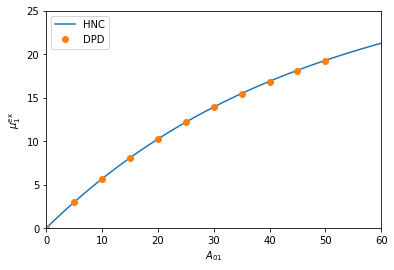

In [19]:
plt.plot(A01, μ_ex, '-', label='HNC')

#μ_rpa = ρ0 * np.pi * A01 / 15
#plt.plot(A01, μ_rpa, '--', label='RPA')

slice = (muref['quantity']=='mu') & muref['file'].str.startswith('muref2')
ser = muref[slice][['A01', 'value']].groupby('A01').mean()['value']
plt.plot(ser.index, ser, 'o', label='DPD')

plt.xlabel(r'$A_{01}$')
plt.ylabel(r'$\mu_1^\mathrm{ex}$')
plt.legend(loc='upper left')
plt.xlim([0, np.max(A01)])
plt.ylim([0, 25])

In [33]:
A01 = np.linspace(0, 60, 13)
μ_ex = np.empty(len(A01))
pmf_overlap = np.empty(len(A01))

for i, A in enumerate(np.flipud(A01)[:-1]):
    φ01 = dpd_potential(A, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, c01q, h01q = soln.hr, soln.cr, soln.cq, soln.hq
    μ_ex[len(A01)-i-1] = excess_chemical_potential(h01, c01, r)
    pmf_overlap[len(A01)-i-1] = - ρ0 / (2*π**2) * simpson(q**2*c01q*h01q, q)

μ_ex[0] = 0.0
pmf_overlap[0] = 0.0

df = pd.DataFrame(np.array([A01, pmf_overlap, μ_ex]).transpose(), columns=['A01', 'PMF0', 'mu_ex'])
df['PMF0+2muex'] = df['PMF0'] + 2*df['mu_ex']
df

,A01,PMF0,mu_ex,PMF0+2muex
0,0.0,0.000000,0.000000,0.000000
1,5.0,-0.302140,2.981029,5.659919
2,10.0,-1.114141,5.661683,10.209225
3,15.0,-2.326902,8.070124,13.813345
4,20.0,-3.850839,10.231833,16.612827
5,25.0,-5.604085,12.170601,18.737117
6,30.0,-7.510564,13.909039,20.307514
7,35.0,-9.501900,15.468705,21.435511
8,40.0,-11.520255,16.869966,22.219677
9,45.0,-13.520316,18.131742,22.743169


(0.0, 59.0)

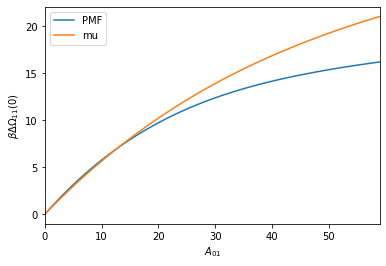

In [39]:
plt.plot(A01, pmf_overlap+2*μ_ex, '-', label='PMF')
plt.plot(A01, μ_ex, '-', label='mu')

plt.xlabel(r'$A_{01}$')
plt.ylabel(r'$\beta \Delta \Omega_{11}(0)$')
plt.legend(loc='upper left')
plt.xlim([0, np.max(A01)])
#plt.ylim([0, 25])


In [34]:
muex = muref[muref['file'].str.startswith('muref2') & (muref['quantity'] == 'mu')].set_index('A01')['value']
muex

A01
0.0      0.00000
5.0      2.98545
10.0     5.67323
15.0     8.08463
20.0    10.24070
25.0    12.16280
30.0    13.87410
35.0    15.40020
40.0    16.77160
45.0    18.02120
50.0    19.17930
Name: value, dtype: float64

In [22]:
saathoff_15 = np.loadtxt('Saathoff_JCP2018_fig5a_A12equals15.dat').transpose()
saathoff_25 = np.loadtxt('Saathoff_JCP2018_fig5a_A12equals25.dat').transpose()
saathoff_35 = np.loadtxt('Saathoff_JCP2018_fig5a_A12equals35.dat').transpose()


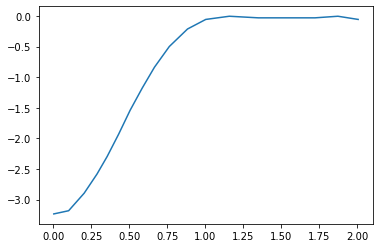

In [24]:
plt.plot(saathoff_15[0], saathoff_15[1])

In [ ]:
A01 = 50
slice = (dimer['quantity'] == 'mu') & (dimer['A01'] == A01)


In [13]:
dimer_all = pd.concat([dimer, dimers], ignore_index=True, sort=False)

In [47]:
A02 = 35
slice = (dimer_all['quantity'] == 'mu') & (dimer_all['A01'] == A01)
dimer_all[slice][['dlength', 'value']].groupby('dlength').mean()['value']


dlength
0.0    19.18570
0.1    19.36925
0.2    19.78445
0.3    20.37710
0.4    21.08415
0.5    21.83880
0.6    22.57455
0.7    23.23005
0.8    23.75365
0.9    24.11560
1.0    24.31718
1.1    24.40615
1.2    24.41640
1.3    24.39770
1.4    24.36810
1.5    24.33940
1.6    24.32725
1.7    24.34180
1.8    24.37490
1.9    24.40165
2.0    24.41120
3.0    24.33660
4.0    24.40080
5.0    24.41910
Name: value, dtype: float64

In [61]:
np.arange(0, 35, 5)

array([ 0,  5, 10, 15, 20, 25, 30])

In [78]:
df2 = pd.DataFrame([(A01, muref_ser[2*A01]) for A01 in df.index if 2*A01 in muref_ser],
                   columns=['A01', 'muref(2*A01)']).set_index('A01')
df2

,muref(2*A01)
A01,
0.0,0.00000
5.0,5.67323
10.0,10.24070
15.0,13.87410
20.0,16.77160
25.0,19.17930


In [89]:
slice = (dimer_all['quantity'] == 'mu') & (dimer_all['dlength'] == 0)
df1 = dimer_all[slice][['A01', 'value']].groupby('A01').mean()
df1.rename(columns={'value': 'PMF(0)'}).join(df2)

,PMF(0),muref(2*A01)
A01,,
0.0,0.000000,0.00000
5.0,5.672815,5.67323
10.0,10.239900,10.24070
15.0,13.876050,13.87410
20.0,16.778500,16.77160
25.0,19.185700,19.17930
30.0,21.313850,NaN
35.0,23.293450,NaN


In [82]:
df1.join(df2)

,value,muref(2*A01)
A01,,
0.0,0.000000,0.00000
5.0,5.672815,5.67323
10.0,10.239900,10.24070
15.0,13.876050,13.87410
20.0,16.778500,16.77160
25.0,19.185700,19.17930
30.0,21.313850,NaN
35.0,23.293450,NaN


/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:105: RuntimeWarning: overflow encountered in exp
  cr_new = np.exp(-vr+er) - er - 1 # iterate with the HNC closure
/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:109: RuntimeWarning: invalid value encountered in subtract
  self.error = np.sqrt(np.trapz((cr_new - cr)**2, dx=self.grid.deltar)) # convergence test
/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:109: RuntimeWarning: overflow encountered in square
  self.error = np.sqrt(np.trapz((cr_new - cr)**2, dx=self.grid.deltar)) # convergence test
/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:105: RuntimeWarning: overflow encountered in exp
  cr_new = np.exp(-vr+er) - er - 1 # iterate with the HNC closure
/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:109: RuntimeWarning: invalid value encountered in subtract
  self.error = np.sqrt(np.trapz((cr_new - cr)**2, dx=self.grid.deltar)) # convergence test
/home/patrick/GitHub/python3-HNC-solver/pyHNC.py:105: RuntimeWarning: overflow enc

Text(0, 0.5, '$\\beta \\Delta \\Omega_{11}(r)$')

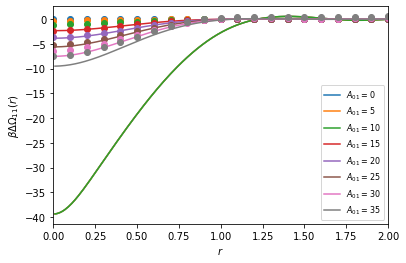

In [17]:
for A01 in np.arange(0, 40, 5):
    φ01 = dpd_potential(A01, r)
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    c01q = grid.fourier_bessel_forward(c01)
    depletion11 = - ρ0 * grid.fourier_bessel_backward(c01q * h01q)
    plt.plot(r, depletion11, label=(r'$A_{01}=' + f'{A01}$'))
    c = plt.gca().lines[-1].get_color()
    slice = (dimer_all['quantity'] == 'mu') & (dimer_all['A01'] == A01)
    ser = dimer_all[slice][['dlength', 'value']].groupby('dlength').mean()['value']
    plt.plot(ser.index, ser-2*muref_ser[A01], 'o', color=c)

#plt.plot(saathoff_15[0], saathoff_15[1], 'kx--', label='Saathoff 15')
#plt.plot(saathoff_25[0], saathoff_25[1], 'rx--', label='Saathoff 25')
#plt.plot(saathoff_35[0], saathoff_35[1], 'bx--', label='Saathoff 35')

    
plt.legend(loc='best', fontsize=8)
plt.xlabel('$r$')
plt.xlim([0, 2])

plt.ylabel(r'$\beta \Delta \Omega_{11}(r)$')


In [32]:
slice = (muref['quantity'] == 'um')
df1 = muref[slice][['A01', 'value']].groupby('A01').mean()*2
df1.rename(columns={'value': '2<U>'}, inplace=True)
df1

,2<U>
A01,
0.0,0.000000
5.0,6.283250
10.0,12.566505
15.0,18.849755
20.0,25.133000
25.0,31.416250
30.0,37.699500
35.0,43.982750
40.0,50.266000


In [34]:
slice = (dimers['quantity'] == 'um')
df2 = dimers[slice][['A01', 'value']].groupby('A01').mean()
df2.rename(columns={'value': '<U1+U2>'}, inplace=True)
df2

,<U1+U2>
A01,
0.0,0.000000
5.0,6.283590
10.0,12.566710
15.0,18.850740
20.0,25.133410
25.0,31.415981
30.0,37.699127
35.0,43.982366
40.0,50.266800


In [35]:
df1.join(df2)

,2<U>,<U1+U2>
A01,,
0.0,0.000000,0.000000
5.0,6.283250,6.283590
10.0,12.566505,12.566710
15.0,18.849755,18.850740
20.0,25.133000,25.133410
25.0,31.416250,31.415981
30.0,37.699500,37.699127
35.0,43.982750,43.982366
40.0,50.266000,50.266800


In [69]:
- ρ0 / (2*π**2) * simpson(q**2*c01q*h01q, q)

-5.604085490618476

In [73]:
df7[df7['A01']==25]

,A01,PMF(0),mu_ex,PMF(0)+2muex
5,25.0,-5.604085,12.170601,18.737117


# 3. Partition coefficients of dimers

Taking the depletion potential from the previous section we can integrate over all configurations of a dimer to obtain its chemical potential:

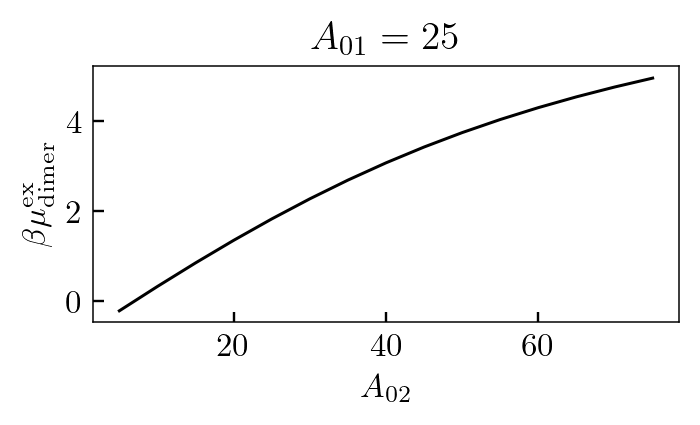

In [10]:
def bond_potential(r, l0=0.5, k=150):
    """Spring force between bonded atoms in a molecule."""
    return k * (r - l0)**2

from scipy.integrate import simpson

def dimer_excess_chemical_potential(A1, A2, l0=0.5, k=150):
    """Excess chemical potential of a non-rigid dimer is found by integrating
    the potential of mean force over all configurations of the two beads.

    Args:
        A1: interaction strength of bead 1 with the solvent.
        A2: interaction strength of bead 2 with the solvent.
        l0: equilbrium length of dimer in a vacuum.
        k: interaction strength between the two beads (a spring constant).
    Returns:
        Excess chemical potential in units of kT.
    """
    φ01, φ02 = [dpd_potential(A, r) for A in [A1, A2]]
    soln = solute.solve(φ01, monitor=verbose)
    h01, c01, h01q = soln.hr, soln.cr, soln.hq
    soln = solute.solve(φ02, monitor=verbose)
    h02, c02, h02q = soln.hr, soln.cr, soln.hq

    # Depletion contribution to potential of mean force
    psi1q, psi2q = [hq / (1 + ρ0*h00q)**0.5 for hq in [h01q, h02q]]
    depletion12 = - ρ0 * grid.fourier_bessel_backward(psi1q*psi2q)

    v12 = bond_potential(r, l0, k)
    φ12 = v12 + depletion12
    return np.log(simpson(4*np.pi * r**2 * np.exp(-φ12), r))

A1 = 25
A2 = np.arange(5, 76, 5)
μ_ex_dimer = [dimer_excess_chemical_potential(A1, A) for A in A2]
plt.plot(A2, μ_ex_dimer)
plt.xlabel('$A_{02}$')
plt.ylabel(r'$\beta \mu_\text{dimer}^\text{ex}$')
plt.title(r'$A_{01} = 25$')
plt.show()


The partition coefficient is obtained from the ratio of excess chemical potentials in two solvents $\alpha$ and $\beta$:
$$
\ln{K_{ij}^{\alpha\beta}}
\equiv
\ln{\left( \frac{c_{ij}^\alpha}{c_{ij}^\beta} \right)}
=
\beta \mu_{ij,\alpha}^\text{ex} - \beta \mu_{ij,\beta}^\text{ex}\,.
$$

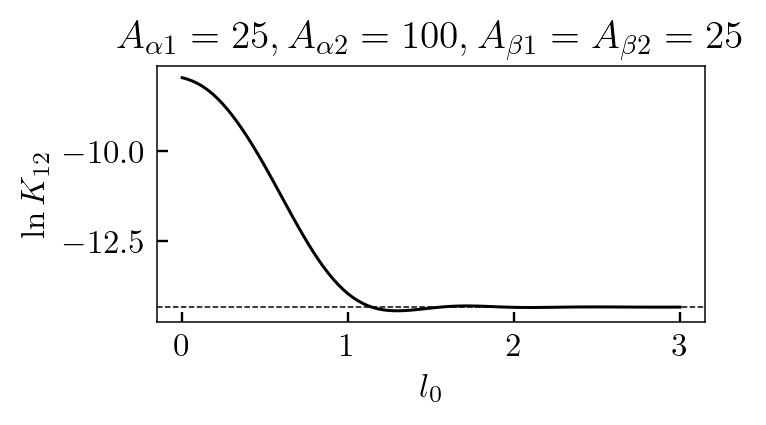

In [11]:
def monomer_partition_coefficient(Aα1, Aβ1):
    """Partition coefficient of a monomer for two reference solvents.
    Args:
        Aα1: interaction coefficient between solute and first solvent.
        Aβ1: interaction coefficient between solute and second solvent.
    Returns:
        Difference between excess chemical potentials in units of kT.
    """
    φα1, φβ1 = [dpd_potential(A, r) for A in [Aα1, Aβ1]]

    soln = solute.solve(φα1, monitor=verbose)
    hα1, cα1, hα1q = soln.hr, soln.cr, soln.hq
    μ_ex_α = excess_chemical_potential(hα1, cα1, r)

    soln = solute.solve(φβ1, monitor=verbose)
    hβ1, cβ1, hβ1q = soln.hr, soln.cr, soln.hq
    μ_ex_β = excess_chemical_potential(hβ1, cβ1, r)

    return μ_ex_β - μ_ex_α

def dimer_partition_coefficient(A1, A2, l0=0.5, k=150):
    """Partition coefficient of a dimer for two reference solvents.
    Args:
        A1: interaction coefficients of first bead with each solvent.
        A2: interaction coefficients of second bead with each solvent.
        l0: equilbrium length of dimer in a vacuum.
        k: interaction strength between the two beads (a spring constant).
    Returns:
        Difference between excess chemical potentials in units of kT.
    """

    K1 = monomer_partition_coefficient(*A1)
    K2 = monomer_partition_coefficient(*A2)

    Aα1, Aβ1 = A1
    Aα2, Aβ2 = A2
    μ_ex_α = dimer_excess_chemical_potential(Aα1, Aα2, l0, k)
    μ_ex_β = dimer_excess_chemical_potential(Aβ1, Aβ2, l0, k)

    return K1 + K2 + μ_ex_α - μ_ex_β

A1 = [25, 25]
A2 = [100, 25]
K1 = monomer_partition_coefficient(*A1)
K2 = monomer_partition_coefficient(*A2)

l0 = np.linspace(0, 3, 100)
logP = [dimer_partition_coefficient(A1, A2, ll) for ll in l0]

plt.plot(l0, logP)
plt.axhline(y=(K1+K2), ls='--', lw=0.5)
plt.xlabel('$l_0$')
plt.ylabel(r'$\ln{K_{12}}$')
plt.title(r'$A_{\alpha 1} = 25, A_{\alpha 2} = 100, A_{\beta 1} = A_{\beta 2} = 25$')
plt.show()